# Data Exploration: Exploring the Dataset



In [63]:
#Import the necessary libraries to start
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("IMDB Dataset.csv") #open the data

In [5]:
df.head(10) #let's view the data set

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
import re #import the necessary libraries

In [9]:
def clean_text(text):
    text = text.lower() #make all the entries lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) #remove all special characters except letters, numbers, and spaces
    return text 

df['cleaned_review'] = df['review'].apply(clean_text) # apply the function to the 'review' column #add the cleaned review col
df.drop(columns = 'review', inplace = True) #remove the original review column
#df.head(10) #verify everything worked 

In [11]:
#We're going to change the words "positive" and "negative" to 1 and 0, respectively

sentiment_numeric = [] #initialize a list

for value in df['sentiment']: #for all the values in this column
    if value == 'positive': #if the word is 'positive'
        sentiment_numeric.append(1) #append a 1 to this same index in our initialized list
    else: #if the word is 'negative'
        sentiment_numeric.append(0) #append a 0 to this same index in our initialized list

df['sentiment'] = sentiment_numeric #change the sentiment column to this list
#df.head(10)

In [13]:
#Import more necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
#Define our parameters and our target
X = df['cleaned_review'].values
y = df['sentiment'].values

In [17]:
#Split into test and train sets 
X_train_og_text, X_test_og_text, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42, stratify = y
)

In [19]:
#Instatiate a TfidfVectorizer object
tfidf = TfidfVectorizer(
    ngram_range = (1,2), #Include both single words and 2 words
    min_df = 5, #Ignore words that don't appear at least 5 times
    max_df = 0.9, #Ignore words that appear in more than 90% of the entries (the, is, etc)
)

In [21]:
#transform our X's: this creates sparse matrices. Each col is a word, and each row is a document. There is 1 in the x,j entry if the xth
#document has the jth word. 

X_train = tfidf.fit_transform(X_train_og_text) 
X_test = tfidf.transform(X_test_og_text)

#print(X_train) #make sure it worked

# Data Modelling

* I create and validate each of the following models:
    * Logistic Regression
    * KNeighborsClassifier

The two models selected for this classification problem were logistic regression and k-nearest neighbors (KNN). Logistic regression was selected for its interpretability and KNN for its ability to perform well without data distribution assumptions. The models were trained on 75% of the data and tested on 25% of it. 


In [23]:
#Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [25]:
LR_clf = LogisticRegression(max_iter = 5000) #Instantiate a LogisticRegression object
LR_clf.fit(X_train, y_train) #fit our LR object to the training data
y_pred = LR_clf.predict(X_test) #predict on test

In [27]:
print("Accuracy:", accuracy_score(y_test, y_pred)) #evaluate the predictions
print(classification_report(y_test, y_pred)) #look at a variety of metrics

Accuracy: 0.9048
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6250
           1       0.90      0.91      0.91      6250

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



In [29]:
from sklearn.model_selection import cross_val_score

In [31]:
X_tfidf = tfidf.fit_transform(X) #transform the entire X has a whole for cross validation

In [33]:
scores = cross_val_score(LR_clf, X_tfidf, y, cv = 5) #instantiate a CV object
mean_accuracy = np.mean(scores) #get the mean scores
print(scores)
print(mean_accuracy)

[0.9073 0.9058 0.8981 0.9036 0.9021]
0.90338


5-fold cross validation was performed to ensure the robustness of the LR model results. The mean accuracy score across 5 folds was 90.34%, which does not differ significantly from the train and test accuracy score.

In [35]:
#Import necessary libraries

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {'n_neighbors': range(1, 10)} #define a parameter search grid. We will test the accuracy with 1-10 neighbors

In [39]:
neigh = KNeighborsClassifier() #instatiate a KNeighborsClassifier object

In [41]:
grid_search = GridSearchCV(neigh, param_grid, cv = 5, scoring = 'accuracy') #make a GridSearchCV object, with 5 fold CV
grid_search.fit(X_train, y_train) #fit the grid search

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, scoring='accuracy')

In [43]:
#print out the best k with the best cross valid score

optimal_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print("Optimal k: ", optimal_k)
print("Best cross-validation accuracy: ", best_score)

Optimal k:  8
Best cross-validation accuracy:  0.7892533333333333


In [45]:
#make a final knn model with the best k neighbors

best_knn = KNeighborsClassifier(n_neighbors = 8)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      6250
           1       0.77      0.80      0.79      6250

    accuracy                           0.78     12500
   macro avg       0.78      0.78      0.78     12500
weighted avg       0.78      0.78      0.78     12500



In [47]:
#cross validate this final model

scores = cross_val_score(best_knn, X_tfidf, y, cv = 5)
mean_accuracy = np.mean(scores)
print(scores)
print(mean_accuracy)

[0.7981 0.7957 0.796  0.7946 0.7885]
0.7945800000000001


5-fold cross validation with the optimal K yielded an accuracy score of 79.5%, which is not significantly greater than the accuracy score yielded from the train and test model. These results suggest that between a logistic regression and KNN model for this data, the former is the better and should be selected. 

# Results


In [49]:
X_train = tfidf.fit_transform(X_train_og_text) #redefine X_train since we overrode the variable earlier
feature_names = tfidf.get_feature_names_out() #extract the feature names from tfidf

In [51]:
coefs = LR_clf.coef_[0] #extract the coefficients for each feature from the LR model

In [53]:
#build an importance of each word df. Importance is based on magnitude of the coefficients
importance = pd.DataFrame({
    'word': feature_names,
    'coef': coefs
})

In [55]:
top_positive = importance.sort_values('coef', ascending = False).head(20) #extract the top words with the largest coefficient for pos
top_negative = importance.sort_values('coef', ascending = True).head(20) #extract the top words with the largest coefficient for neg

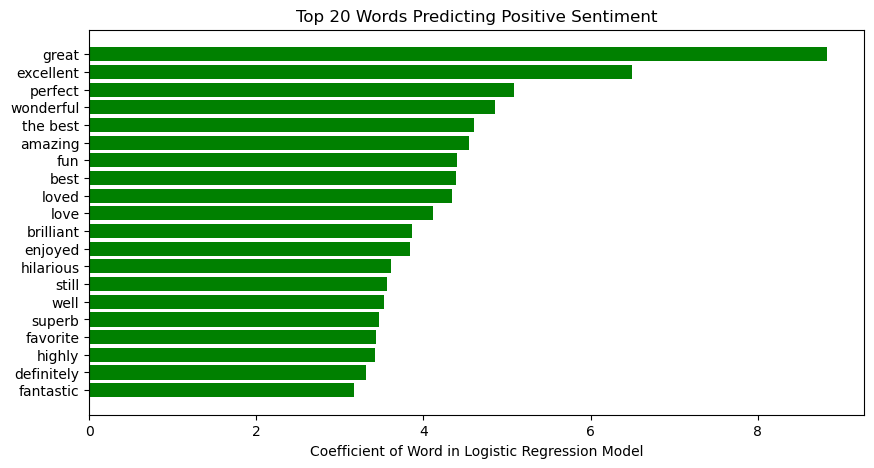

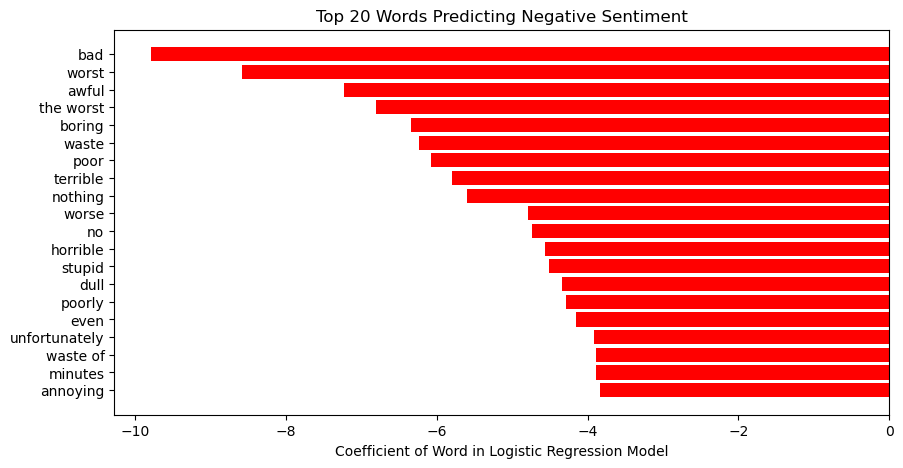

In [57]:
#graph these words and their coefficients

import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))
plt.barh(top_positive['word'][::-1], top_positive['coef'][::-1], color = 'green')
plt.title("Top 20 Words Predicting Positive Sentiment")
plt.xlabel("Coefficient of Word in Logistic Regression Model")
plt.show()

plt.figure(figsize = (10,5))
plt.barh(top_negative['word'][::-1], top_negative['coef'][::-1], color = 'red')
plt.title("Top 20 Words Predicting Negative Sentiment")
plt.xlabel("Coefficient of Word in Logistic Regression Model")
plt.show()

These figures show that the words “great,” “excellent,” “bad,” and “worst” have the largest coefficients in magnitude. These words sway the classifications significantly in either the direction of the positive or negative sentiment. These figures also show that there is some noise in the data; words such as “still” and “well” have large positive coefficients, meaning they are associated with the ‘positive’ classification. However, these words can easily appear in negative reviews. For a model with better accuracy scores, such words should be removed.

In [59]:
from sklearn.decomposition import TruncatedSVD

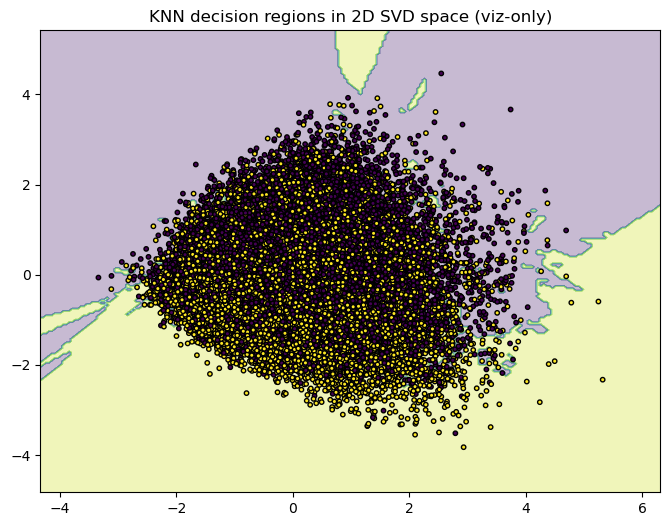

In [65]:
#we want to visualize the knn, but we cannot do this for all of the observations. So, we use Singular Value Decomposition to pick the 2 most
#important directions that the observations go in and visualize those. 

#I've learned about SVDs in Linear Algebra (MATH-304) and Computational Linear Algebra (MATH-406)

svd = TruncatedSVD(n_components = 2, random_state = 42) #instatiate a TruncatedSVD object and specify that we only want the top 2 singular vals
X_train_2d = svd.fit_transform(X_train) #fit the svd model to the train data so we can extract these values
X_test_2d  = svd.transform(X_test)  #same with test data

#Standardize the vectors so the graph is easier to interpret
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d  = scaler.transform(X_test_2d)

#perform knn again
best_knn.fit(X_train_2d, y_train)

#plot the graph!!!
h = 0.05
x_min, x_max = X_train_2d[:,0].min()-1, X_train_2d[:,0].max()+1
y_min, y_max = X_train_2d[:,1].min()-1, X_train_2d[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha = 0.3)
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train, s=10, edgecolor='k')
plt.title("KNN decision regions in 2D SVD space (viz-only)")
plt.show()